In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import KeyFunctions as me
import skopt as skopt
import warnings

warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")

RandState = 117

In [2]:
from sklearn.model_selection import train_test_split

#Import Full R6g Dataset
df, labels = me.ConstructCombinedDataset(3)

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()
display(labels)

['10-5', '10-9', '10-11', '10-14', '10-16']

In [3]:
#Scale Dataset

from sklearn.preprocessing import StandardScaler

Scale = StandardScaler()

X_tn = Scale.fit_transform(X_tn)
X_tt = Scale.transform(X_tt)

In [4]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tn, y_tn)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tn, y_tn)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.72727273, 0.72727273, 0.8       , 0.8       , 0.7       ])

0.750909090909091

0.16599683761596679

In [5]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, 472, 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 4,
                      return_train_score = True, random_state = RandState, cv = 5)
RFBS = Bayes.fit(X_tn, y_tn)
display()

display(RFBS.best_params_)
ypred = RFBS.predict(X_tt)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'gini'),
             ('max_features', 12),
             ('n_estimators', 53)])

0.7909090909090908

0.0856670471955618

0.06596207618713379

In [6]:
from sklearn.metrics import confusion_matrix
y_pred = RFBS.predict(X_tt)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMNT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 6, Predicted: 10-9; Actual: 10-5'

'Incorrect Prediction at 10, Predicted: 10-11; Actual: 10-9'

'Total Predictions: 12'

'Total Errors: 2'

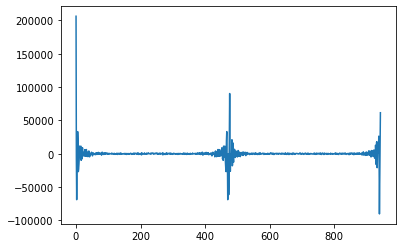

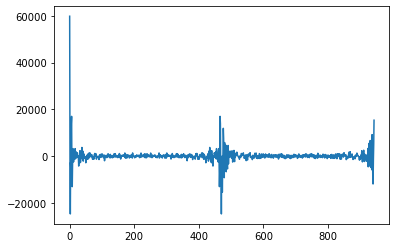

In [7]:
#Apply Fourier Transform to Training and Testing Data
#Fourier Transform Performs Best Without Scaling
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnf = np.fft.fft(X_tn)
X_ttf = np.fft.fft(X_tt)

#Data is stored as columns of all real values followed by columns of all imaginary values.
X_tnf = np.append(np.real(X_tnf), np.imag(X_tnf), axis = 1)
X_ttf = np.append(np.real(X_ttf), np.imag(X_ttf), axis = 1)

plt.figure()
plt.plot(X_tnf[1, :])
plt.figure()
plt.plot(X_tnf[7, :]);

In [8]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tnf, y_tn)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tnf, y_tn)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.63636364, 0.90909091, 0.9       , 0.8       , 0.8       ])

0.809090909090909

0.15481929779052733

In [9]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, np.shape(X_tnf)[1], 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 4,
                      return_train_score = True, random_state = RandState, cv = 5)
RFBS = Bayes.fit(X_tnf, y_tn)
display()

display(RFBS.best_params_)
ypred = RFBS.predict(X_ttf)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'gini'),
             ('max_features', 570),
             ('n_estimators', 10)])

0.8618181818181819

0.10275542655232577

0.04797172546386719

In [10]:
y_pred = RFBS.predict(X_ttf)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMFT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 10, Predicted: 10-11; Actual: 10-9'

'Total Predictions: 12'

'Total Errors: 1'

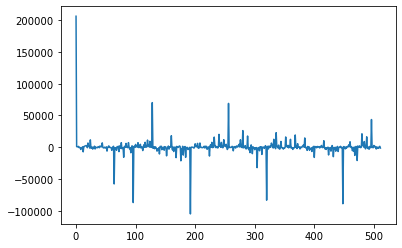

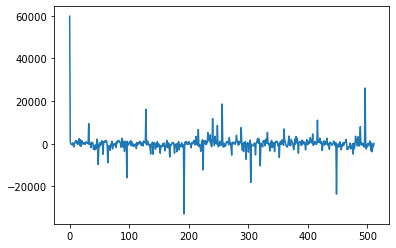

In [11]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tn)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)

plt.figure()
plt.plot(X_tnh[1, :])
plt.figure()
plt.plot(X_tnh[7, :]);

In [12]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tnh, y_tn)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tnh, y_tn)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.81818182, 1.        , 0.9       , 0.7       , 0.9       ])

0.8636363636363636

0.17389140129089356

In [13]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, np.shape(X_tnh)[1], 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 4,
                      return_train_score = True, random_state = RandState, cv = 5)
RFBS = Bayes.fit(X_tnh, y_tn)
display()

display(RFBS.best_params_)
ypred = RFBS.predict(X_tth)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'entropy'),
             ('max_features', 17),
             ('n_estimators', 166)])

0.8836363636363638

0.07121147646387685

0.2956209182739258

In [14]:
y_pred = RFBS.predict(X_tth)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMHT = confusion_matrix(y_tt, y_pred, labels = labels)

'Total Predictions: 12'

'Total Errors: 0'

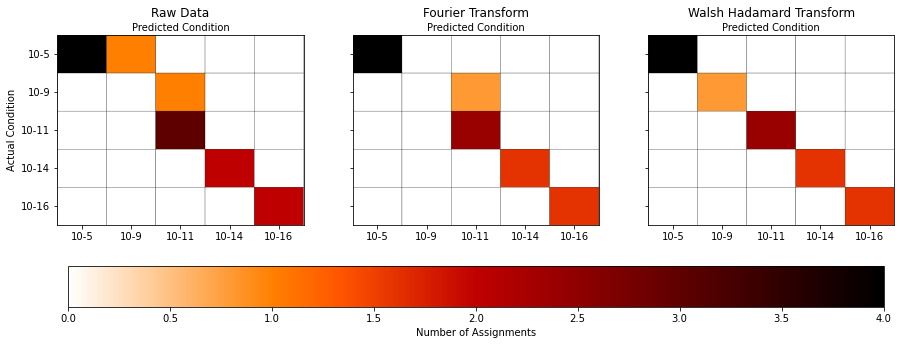

In [15]:

fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMNT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');

In [16]:
display(CMHT)

array([[5, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 2]], dtype=int64)